# Modular Virus Simulation

## Required libraries

In [1]:
using Markdown
using InteractiveUtils
using Random, Distributions, StatsBase, Parameters, DataFrames, Plots
using CSV, Tables

## Constants and Parameters

### Fixed Parameters and Constants
Let's start with the physical constants that we are not seeking to change:

In [2]:
#physical constants
const kt_boltzmann = 0.001987204118 * (273.15 + 37)
const ΔΔG = Normal(1.0, 1.7)

Normal{Float64}(μ=1.0, σ=1.7)

And then let's set up the gene-level architecture. In this simulation we have assigned genes to three modules. For each module we imagine a different genetic architecture with implications for epistasis.

| Module Name | Genetic Architecture | Type of Epistasis | Variance Penalty |
|-------------|---------------------|-------------------|-------------|
| non-essential | independent contributions | arithmetic mean | none |
| assembly | stoichiometric balance | geometric mean | moderate |
| replication | linear with rate limiting steps | minimum | high |
| host interaction | orthogonal interactions | product | maximal |

So Let's define these module sizes and characteristics:

In [4]:
# module configuration
const module_sizes = Dict(
    
    :non_essential => 3, #2
    # A* (blocks super-inf, non-essential and overlapping), K (optimises burst size, non-essential)
    
    :assembly => 3, #3
    # B (internal scaffolding), D (external scaffolding), F (major capsid) - actually H involved in stoichiometry
    
    :replication => 3, #2
    # A (rolling circle init, actually overlaps with A), J (ssDNA binding)
    
    :host_interaction => 3, #4
    # C (DNA packaging), E (host cell lysis), G (major spike), H (DNA pilot/minor spike)

)
const module_names = [:non_essential, :assembly, :replication, :host_interaction]

# total number of genes
const G = sum(values(module_sizes)) # number_of_genes

12

Let us define some other parameters that are not physical constants but which will remain constant:

In [5]:
#fixed parameters
const sim_length = 500 # number of generations 500
const F_init = -5.0 # initial_free_energy (of all proteins)

-5.0

### Variable Parameters
And now for the parameters that we will change and sweep through:

In [6]:
#variable parameters
const U_default = Poisson(5.0) # mutation_rate
const L_default = 0.1 # lethal fraction
# L will be defined in the loop
const N_default = 10000 # start_popsize
const K_default = 10000 # carrying_capacity
const R_default = 9 # fecundity
#const Rep = 1 # replicate number
const start_fitness = (1 / (1 + ℯ^(F_init/kt_boltzmann)))^G

0.996409846182865

## Defining the Virus

We represent the virus as a Julia Struct. It contains 2 dictionaries (where the keys are module names and the values are lists, one for each module). These dictionaries are for mutation counts (μ_counts) and for ΔG values (ΔG_values). We also see an atomic entry for fitness.

In [7]:
mutable struct ModularVirus
    μ_counts::Dict{Symbol, Vector{Int64}}
    ΔG_values::Dict{Symbol, Vector{Float64}}
    fitness::Float64
end

We have this convenience function for initializing a new modular virus and we preload our dictionaries with zero entries for mutation numbers and free energy, while setting fitness to 1 and zombie to false:

In [8]:
# constructor for clean initialization
function ModularVirus(initial_ΔG::Float64 = F_init, initial_fitness::Float64 = start_fitness)
    μ_counts = Dict(name => zeros(Int64, module_sizes[name]) for name in module_names)
    ΔG_values = Dict(name => fill(initial_ΔG, module_sizes[name]) for name in module_names)
    return ModularVirus(μ_counts, ΔG_values, initial_fitness)
end

ModularVirus

Test it:

In [9]:
Quentin = ModularVirus()

ModularVirus(Dict(:replication => [0, 0, 0], :assembly => [0, 0, 0], :host_interaction => [0, 0, 0], :non_essential => [0, 0, 0]), Dict(:replication => [-5.0, -5.0, -5.0], :assembly => [-5.0, -5.0, -5.0], :host_interaction => [-5.0, -5.0, -5.0], :non_essential => [-5.0, -5.0, -5.0]), 0.996409846182865)

Force add a mutation:

In [10]:
for module_name in module_names
    Quentin.μ_counts[module_name][1] = 1
    Quentin.ΔG_values[module_name][1] = -1.0
end
Quentin

ModularVirus(Dict(:replication => [1, 0, 0], :assembly => [1, 0, 0], :host_interaction => [1, 0, 0], :non_essential => [1, 0, 0]), Dict(:replication => [-1.0, -5.0, -5.0], :assembly => [-1.0, -5.0, -5.0], :host_interaction => [-1.0, -5.0, -5.0], :non_essential => [-1.0, -5.0, -5.0]), 0.996409846182865)

## Epistasis and Fitness Calculations

Here we have functions for instantiating epistasis in different ways for each module:

In [11]:
function nonessential_additive(gene_ΔGs::Vector{Float64})
    # Additive contributions
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in gene_ΔGs]
    return mean(stabilities)
end

function assembly_epistasis(assembly_ΔGs::Vector{Float64})
    # Stoichiometric balance: variance in stabilities hurts fitness
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in assembly_ΔGs]
    # Geometric mean naturally penalizes imbalance
    return prod(stabilities)^(1/length(stabilities))
end

function replication_epistasis(replication_ΔGs::Vector{Float64})
    # Rate-limiting: weakest link dominates
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in replication_ΔGs]
    return minimum(stabilities)
end

function host_module_independent(host_ΔGs::Vector{Float64})
    # Independent effects but negatives propagate
    stabilities = [1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in host_ΔGs]
    return prod(stabilities)
end

host_module_independent (generic function with 1 method)

Now we can generate a struct-modifying update fitness function:

In [12]:
function update_fitness!(virus::ModularVirus)
    nonessential_contrib = nonessential_additive(virus.ΔG_values[:non_essential])
    assembly_contrib = assembly_epistasis(virus.ΔG_values[:assembly])
    replication_contrib = replication_epistasis(virus.ΔG_values[:replication])
    host_contrib = host_module_independent(virus.ΔG_values[:host_interaction])
    
    virus.fitness = assembly_contrib * replication_contrib * host_contrib * nonessential_contrib
end

update_fitness! (generic function with 1 method)

Try it:

In [13]:
println("Non-essential: ", nonessential_additive(Quentin.ΔG_values[:non_essential]))
println("Assembly: ", assembly_epistasis(Quentin.ΔG_values[:assembly]))
println("Replication: ", replication_epistasis(Quentin.ΔG_values[:replication]))
println("Host Interaction: ", host_module_independent(Quentin.ΔG_values[:host_interaction]))

Non-essential: 0.9448469353699451
Assembly: 0.94152750331792
Replication: 0.8351401519356596
Host Interaction: 0.8346396891704236


In [14]:
update_fitness!(Quentin)

0.6200873426274377

In [15]:
Quentin.fitness

0.6200873426274377

## Making New Mutations

Enumerate and apply new mutations to a virus:

In [16]:
function mutate!(virus::ModularVirus, L, U, ΔΔG) 
    number_of_mutations = only(rand(U, 1))
    ΔΔG_values = rand(ΔΔG, number_of_mutations)
    
    # we choose modules proportionally to their size
    module_probs = [module_sizes[name] for name in module_names] ./ G
    
    for i in 1:number_of_mutations
        # Select module based on proportional targeting
        module_choice = rand(Categorical(module_probs))
        module_name = module_names[module_choice]
        
        # Select gene within module
        module_size = module_sizes[module_name]
        gene_index = rand(1:module_size)
        
        # Apply mutation to appropriate dictionary [and module therein][and gene]
        virus.μ_counts[module_name][gene_index] += 1
        virus.ΔG_values[module_name][gene_index] += ΔΔG_values[i]
        
        # Lethal mutation check
        if rand() < L
            virus.fitness = 0
            return virus.fitness
        end
    end
    
    # Update fitness if virus is still viable
    (virus.fitness > 0) && (update_fitness!(virus))
    
    return virus.fitness
end

mutate! (generic function with 1 method)

## Reproduction

Here is a reproduction function:

In [17]:
# Creates new offspring virus by copying parent + its mutations
function reproduce(parent::ModularVirus, L, U, ΔΔG)
    sprog = deepcopy(parent)
    mutate!(sprog, L, U, ΔΔG)
    return sprog
end

reproduce (generic function with 1 method)

## Creating a Population

Here is a convenience function to make a new population of viruses:

In [18]:
# Creates initial virus population
function initialize_population(N, start_fitness)
    return [ModularVirus() for _ in 1:N]
end

initialize_population (generic function with 1 method)

## Helper Functions

Here are some key helper functions that facilitate selection (get weights) or the selection of an integer number of offspring (probabilistic round):

In [19]:
# Used to implement fitness-proportional selection
function get_weights(populace)
    fitness_values = [v.fitness for v in populace]
    total = sum(fitness_values)
    fitness_values ./= total  # in-place division to avoid new array
    return Weights(fitness_values)
end

# Round a floating-point number to an integer
function probabilistic_round(number)
    base = floor(Int, number)
    return base + (rand() < number - base)
    # bracketed boolean expression evaluates to 0 or 1
end

# Helper function to get all ΔG values from a ModularVirus
function get_all_ΔG(virus::ModularVirus)
    all_ΔG = Float64[]
    for module_name in module_names
        append!(all_ΔG, virus.ΔG_values[module_name])
    end
    return all_ΔG
end

# Helper function to get all mutation counts from a ModularVirus  
function get_all_mutations(virus::ModularVirus)
    return sum(sum(virus.μ_counts[module_name]) for module_name in module_names)
end

# Helper function to get module-specific mean statistics
function get_module_stats(populace, module_name::Symbol)
    mut_counts = [sum(v.μ_counts[module_name]) for v in populace]
    ΔG_values = [mean(v.ΔG_values[module_name]) for v in populace]
    return mean(mut_counts), mean(ΔG_values)
end

get_module_stats (generic function with 1 method)

## Report and Plotting Functions

### Report Initialization and Filling Functions

In [20]:
# Creates empty DataFrame with module-specific columns
function initialize_report()
    report = DataFrame(
        # Main metrics
        psiz = Int[], 
        q1fit = Float64[], 
        meanfit = Float64[],
        q2fit = Float64[], 
        maxfit = Float64[], 
        minfree = Float64[],
        meanfree = Float64[], 
        maxfree = Float64[], 
        minmut = Float64[],
        meanmut = Float64[], 
        maxmut = Float64[],
        # Module-specific mutation counts
        replication_meanmut = Float64[],
        assembly_meanmut = Float64[],
        host_meanmut = Float64[],
        # Module-specific free energies  
        replication_meanfree = Float64[],
        assembly_meanfree = Float64[],
        host_meanfree = Float64[]
    )
    return report
end

# Updates DataFrame with both original and module-specific metrics
function report_update!(populace, report)
    # Original metrics
    fitness_values = [v.fitness for v in populace]
    all_ΔG_per_virus = [get_all_ΔG(v) for v in populace]
    all_mutations_per_virus = [get_all_mutations(v) for v in populace]
    
    # Module-specific metrics
    rep_mut, rep_free = get_module_stats(populace, :replication)
    asm_mut, asm_free = get_module_stats(populace, :assembly)
    host_mut, host_free = get_module_stats(populace, :host_interaction)
    
    # Precompute ΔG statistics for efficiency
    ΔG_mins = [minimum(ΔG_list) for ΔG_list in all_ΔG_per_virus]
    ΔG_means = [mean(ΔG_list) for ΔG_list in all_ΔG_per_virus]
    ΔG_maxs = [maximum(ΔG_list) for ΔG_list in all_ΔG_per_virus]
    
    push!(report, (
        psiz = length(populace),
        q1fit = quantile(fitness_values, 0.25),
        meanfit = mean(fitness_values),
        q2fit = median(fitness_values),
        maxfit = maximum(fitness_values),
        minfree = mean(ΔG_mins),
        meanfree = mean(ΔG_means),
        maxfree = mean(ΔG_maxs),
        minmut = minimum(all_mutations_per_virus),
        meanmut = mean(all_mutations_per_virus),
        maxmut = maximum(all_mutations_per_virus),
        replication_meanmut = rep_mut,
        assembly_meanmut = asm_mut,
        host_meanmut = host_mut,
        replication_meanfree = rep_free,
        assembly_meanfree = asm_free,
        host_meanfree = host_free
    ))
end

report_update! (generic function with 1 method)

### Plotting Function

In [21]:
#creates plots including module-specific panels
function plot_simulation(report)
    abscissa = 1:size(report, 1)
    
    p1 = plot(abscissa, report.psiz, 
        ylims = (0, maximum(report.psiz)),
        label = "pop size", linewidth = 3, title = "A) Population Size")
        
    p2 = plot(abscissa, [report.q1fit report.meanfit report.q2fit report.maxfit],
        label = ["Q1 fitness" "mean fitness" "median fitness" "max fitness"], 
        linewidth = 3, title = "B) Fitness Distribution")
        
    p3 = plot(abscissa, [report.minfree report.meanfree report.maxfree],
        label = ["min ΔG" "mean ΔG" "max ΔG"],
        linewidth = 3, title = "C) Free Energy Distribution")
        
    p4 = plot(abscissa, [report.minmut report.meanmut report.maxmut],
        label = ["min mutations" "mean mutations" "max mutations"],
        linewidth = 3, title = "D) Total Mutations")
        
    p5 = plot(abscissa, [report.replication_meanmut report.assembly_meanmut report.host_meanmut],
        label = ["replication" "assembly" "host interaction"],
        linewidth = 3, title = "E) Mutations by Module")
        
    p6 = plot(abscissa, [report.replication_meanfree report.assembly_meanfree report.host_meanfree],
        label = ["replication" "assembly" "host interaction"],
        linewidth = 3, title = "F) Mean ΔG by Module")
    
    plot(p1, p2, p3, p4, p5, p6, 
        titleloc = :left, 
        titlefont = font(12), 
        layout = (3, 2), 
        size = (1000, 1000))
end

plot_simulation (generic function with 1 method)

## Simulation Proper

Let's start with a function to replicate the next generation:

In [22]:
# Simulates one generation of the population. fitness pushed to next generation
function synchronized_generation(populace, L, U, ΔΔG, R) 
    next_generation = ModularVirus[]
    # equivalent to Array{ModularVirus,1}() and eliminates type checking later
    
    for parent in populace
        offspring_count = probabilistic_round(R * parent.fitness)
        for r in 1:offspring_count
            child = reproduce(parent, L, U, ΔΔG)
            # Only add viable offspring (short-circuit evaluation)
            (child.fitness > 0) && push!(next_generation, child)
        end
    end
    
    return next_generation
end

synchronized_generation (generic function with 1 method)

Now let's generate a function that yields a complete simulation:

In [23]:
# Runs main sim and collects data into DataFrame
function synchronized_simulation(L, U, ΔΔG, R, N, K, start_fitness, sim_length; 
                                report_frequency = 20)
    # Initialize population and reporting
    population = initialize_population(N, start_fitness)
    report = initialize_report()
    
    generation = 0
    max_generations = sim_length
    
    while generation < max_generations
        generation += 1
        
        # Progress reporting
        if generation % report_frequency == 0
            println("Generation: $generation, Population size: $(length(population))")
        end
        
        # Collect data before selection/reproduction
        report_update!(population, report)
        
        # Generate next generation
        population = synchronized_generation(population, L, U, ΔΔG, R)
        population_size = length(population)
        
        # Apply carrying capacity constraint
        if population_size > K
            population = sample(population, K, replace = false)
        elseif population_size == 0
            println("Population extinct at generation $generation")
            break
        end
    end
    
    # Final report update if simulation completed
    if length(population) > 0
        report_update!(population, report)
    end
    
    return report, population
end

synchronized_simulation (generic function with 1 method)

In [36]:
# Convenience function with default parameters
function run_simulation(; L = 0.27, U = U_default, R = R_default, N = N_default, K = K_default, 
                        sim_length = 400, report_frequency = 20)
    # These would need to be defined based on your parameter choices
    # U = Poisson distribution for mutations
    # ΔΔG = distribution for mutation effects  
    # F = initial free energy
    # start_fitness = calculated initial fitness
    
    return synchronized_simulation(L, U, ΔΔG, R, N, K, start_fitness, sim_length;
                                 report_frequency = report_frequency)
end

run_simulation (generic function with 1 method)

# Run the Simulation

Generation: 20, Population size: 9811
Generation: 40, Population size: 5028
Generation: 60, Population size: 1432
Generation: 80, Population size: 254
Generation: 100, Population size: 4
Population extinct at generation 100


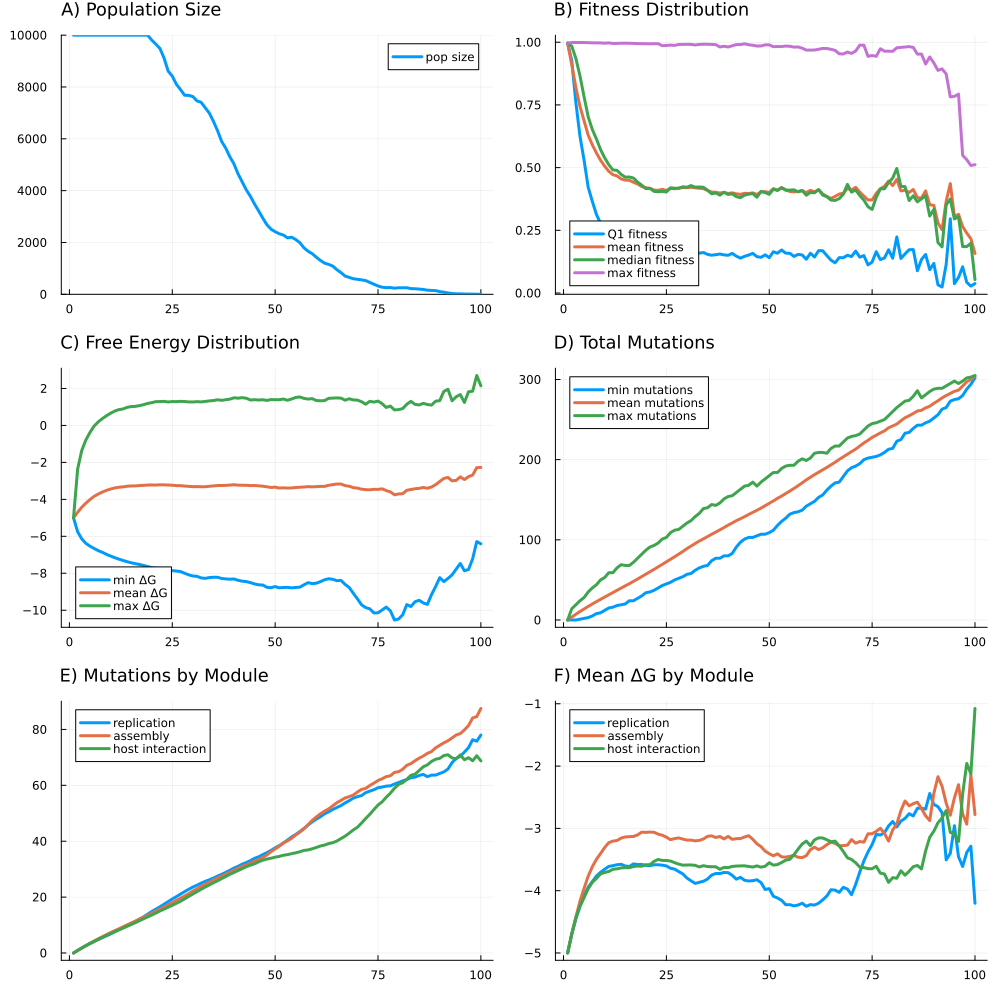

In [37]:
# Run the simulation
report, final_population = run_simulation()

# Plot the results
plot_simulation(report)

In [38]:
report

Row,psiz,q1fit,meanfit,q2fit,maxfit,minfree,meanfree,maxfree,minmut,meanmut,maxmut,replication_meanmut,assembly_meanmut,host_meanmut,replication_meanfree,assembly_meanfree,host_meanfree
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10000,0.99641,0.99641,0.99641,0.99641,-5.0,-5.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,-5.0,-5.0
2,10000,0.927199,0.910635,0.984189,0.998822,-5.75439,-4.69864,-2.36119,0.0,3.6327,14.0,0.9001,0.906,0.9189,-4.70574,-4.69673,-4.69074
3,10000,0.759274,0.819216,0.935691,0.998909,-6.14053,-4.42998,-1.35637,0.0,7.1699,19.0,1.7692,1.7923,1.7961,-4.45207,-4.42265,-4.43613
4,10000,0.625147,0.743523,0.86574,0.998882,-6.38189,-4.20544,-0.783498,1.0,10.5408,24.0,2.5815,2.6748,2.5994,-4.2526,-4.1702,-4.24961
5,10000,0.529086,0.686385,0.781916,0.998715,-6.53457,-4.0125,-0.376586,2.0,13.7865,28.0,3.3712,3.4841,3.3647,-4.07411,-3.96155,-4.1111
6,10000,0.421282,0.629408,0.702484,0.998181,-6.65639,-3.83898,-0.0355663,3.0,16.9466,35.0,4.094,4.3009,4.1435,-3.9433,-3.76603,-3.96783
7,10000,0.365429,0.591023,0.652009,0.99752,-6.77459,-3.71419,0.191507,5.0,19.9676,40.0,4.8115,5.0822,4.8669,-3.85347,-3.61565,-3.86568
8,10000,0.313035,0.558441,0.614387,0.997229,-6.86693,-3.60649,0.366848,8.0,22.8707,44.0,5.5231,5.8236,5.5466,-3.76397,-3.49573,-3.80305
9,10000,0.278212,0.529364,0.571972,0.99713,-6.97556,-3.51421,0.522478,9.0,25.7591,50.0,6.1861,6.5759,6.2463,-3.70463,-3.4038,-3.72939


Generation: 20, Population size: 4000
Generation: 40, Population size: 4000
Generation: 60, Population size: 4000
Generation: 80, Population size: 4000
Generation: 100, Population size: 4000
Generation: 120, Population size: 4000
Generation: 140, Population size: 4000
Generation: 160, Population size: 4000
Generation: 180, Population size: 4000
Generation: 200, Population size: 4000


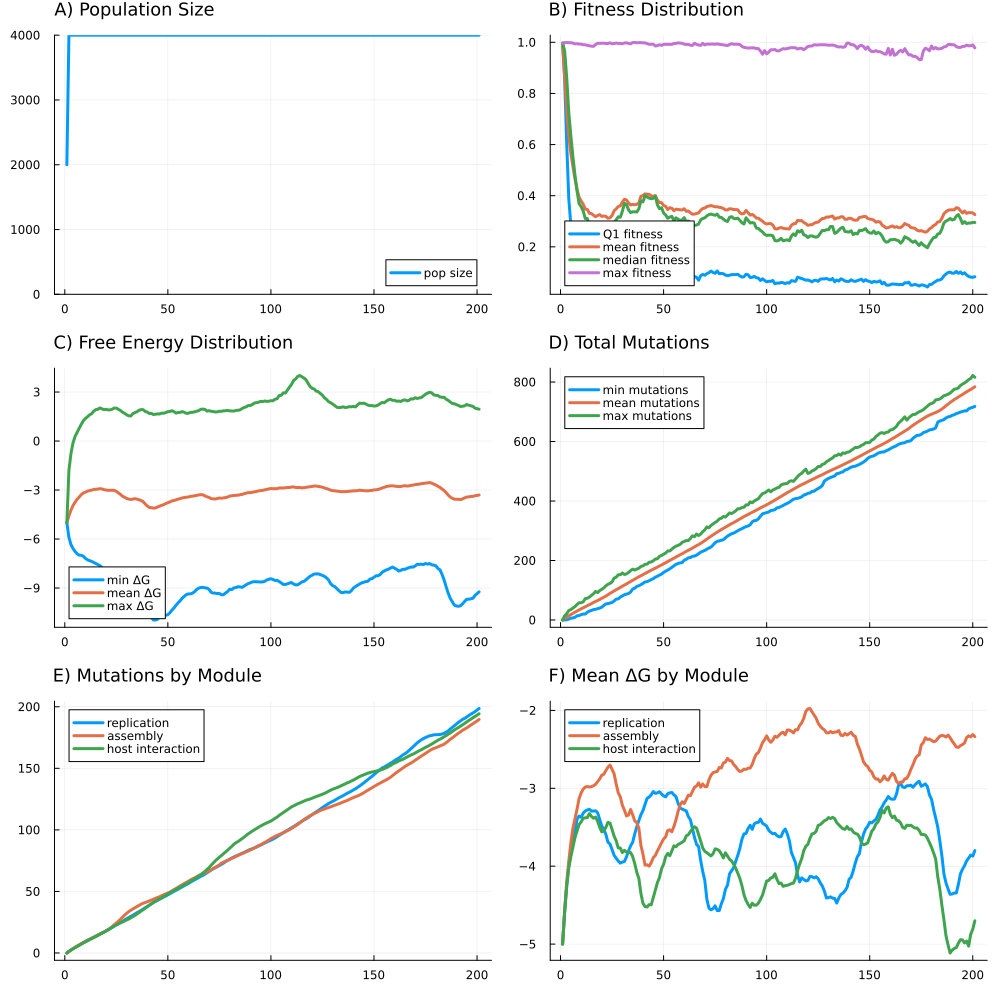

In [39]:
# Example with custom parameters
report, final_population = run_simulation(L = 0.02, R = 10, sim_length = 200, N = 2000, K = 4000)
plot_simulation(report)

# Parameter Sweeps

In [12]:
using Random, CSV, DataFrames

function run_simulation(; L = 0.01, U = nothing, ΔΔG = nothing, R = 2.0, 
                       N = 1000, K = 10000, F = -1.0, sim_length = 1000,
                       seed = nothing, output_dir = nothing, 
                       save_files = false, report_frequency = 20)
    
    # Set random seed for reproducibility
    if seed !== nothing
        Random.seed!(seed)
    else
        seed = rand(Int)
        Random.seed!(seed)
    end
    
    # Calculate derived parameters
    start_fitness = (1 / (1 + ℯ^(F/kt_boltzmann)))^G
    
    # Run simulation
    println("Starting simulation with seed $seed...")
    report, final_population = synchronized_simulation(
        L, U, ΔΔG, R, N, K, F, start_fitness, sim_length;
        report_frequency = report_frequency
    )
    
    # Add parameter columns to report for tracking
    report[!, :L] .= L
    report[!, :N] .= N  
    report[!, :R] .= R
    report[!, :K] .= K
    report[!, :F] .= F
    report[!, :seed] .= seed
    report[!, :sim_length] .= sim_length
    
    # Add distribution parameters if provided
    if U !== nothing && hasmethod(mean, (typeof(U),))
        report[!, :U_mean] .= mean(U)
    end
    if ΔΔG !== nothing && hasmethod(mean, (typeof(ΔΔG),))
        report[!, :ΔΔG_mean] .= mean(ΔΔG)
    end
    
    # File saving logic
    if save_files && output_dir !== nothing
        mkpath(output_dir)
        
        # Generate descriptive filenames
        U_str = U !== nothing ? "U$(Int(round(mean(U))))" : "Udef"
        base_name = "L$(L)_N$(N)_R$(R)_$(U_str)_seed$(seed)"
        
        csv_filename = joinpath(output_dir, "$(base_name).csv")
        png_filename = joinpath(output_dir, "$(base_name).png")
        
        # Save CSV
        CSV.write(csv_filename, report)
        println("Report saved to: $csv_filename")
        
        # Save plot
        p = plot_simulation(report)
        savefig(p, png_filename)
        println("Plot saved to: $png_filename")
        
        return report, final_population, csv_filename, png_filename
    else
        return report, final_population
    end
end

# Batch simulation function for parameter sweeps
function run_parameter_sweep(param_ranges::Dict; base_dir = "simulation_results", 
                           num_runs = 5, save_master_csv = true)
    
    mkpath(base_dir)
    master_results = DataFrame()
    
    # Get all parameter combinations
    param_names = collect(keys(param_ranges))
    param_values = collect(values(param_ranges))
    
    for param_combo in Iterators.product(param_values...)
        params = Dict(zip(param_names, param_combo))
        
        println("Running parameter combination: $params")
        
        # Create directory for this parameter set
        param_str = join(["$k$(v)" for (k,v) in params], "_")
        param_dir = joinpath(base_dir, param_str)
        mkpath(param_dir)
        
        for run in 1:num_runs
            println("  Run $run/$num_runs")
            
            run_dir = joinpath(param_dir, "run_$run")
            
            # Run simulation with current parameters
            result = run_simulation(;
                params...,
                seed = rand(Int),
                output_dir = run_dir,
                save_files = true
            )
            
            # Collect results for master CSV
            if save_master_csv && length(result) >= 1
                report = result[1]
                append!(master_results, report)
            end
        end
    end
    
    # Save master CSV
    if save_master_csv && !isempty(master_results)
        master_csv = joinpath(base_dir, "master_results.csv")
        CSV.write(master_csv, master_results)
        println("Master results saved to: $master_csv")
    end
    
    return master_results
end

# Example usage:
# Single run with file saving
# report, pop = run_simulation(L = 0.05, seed = 12345, 
#                             output_dir = "results/test_run", save_files = true)

# Parameter sweep
# results = run_parameter_sweep(
#     Dict(:L => 0.0:0.1:1.0, :N => [1000, 5000], :R => [1.5, 2.0, 2.5]);
#     base_dir = "parameter_sweep", num_runs = 3
# )

run_parameter_sweep (generic function with 1 method)

## Re-visit in Parameter Sweep Code Check

In [ ]:
#simulation run with the paramaters at the top 
function run_sim(seed::Int, output_dir::String, L::Float64, N::Int, U_poisson::Poisson, R::Int, K::Int) # L, N, U, R, K are now arguments
    Random.seed!(seed)

    variable1 = "L$(L)"
    variable2 = "N$(N)"
    variable3 = "U$(Int(mean(U_poisson)))" # Extract mean from Poisson
    variable4 = "K$(K)"
    variable5 = "R$(R)"
    seed_str = "$seed"

    csv_filename = joinpath(output_dir, "$(variable1)_$(variable2)_$seed_str.csv")
    png_filename = joinpath(output_dir, "$(variable1)_$(variable2)_$seed_str.png")

    synchronized_report = synchronized_simulation(L) # Pass L here

    #Add new columns for L, N, seed, U, R, K
    synchronized_report[!, :L] .= L
    synchronized_report[!, :N] .= N
    synchronized_report[!, :seed] .= seed
    synchronized_report[!, :U] .= Int(mean(U_poisson)) # Store the mean of Poisson U
    synchronized_report[!, :R] .= R
    synchronized_report[!, :K] .= K

    CSV.write(csv_filename, synchronized_report)
    plot_simulation(synchronized_report) # Plot after adding columns to report if they affect plot
    png(png_filename)

    #Combine to master CSV document based on N
    master_csv_dir = joinpath(base_dir, "master_csvs")
    mkpath(master_csv_dir)
    master_csv_filename = joinpath(master_csv_dir, "master_N$(N).csv")

    #Check if master CSV exists to determine if headers are needed
    if !isfile(master_csv_filename) || filesize(master_csv_filename) == 0
        CSV.write(master_csv_filename, synchronized_report, header=true)
    else
        CSV.write(master_csv_filename, synchronized_report, append=true, header=false)
    end

    return csv_filename, png_filename
end

base_dir = "C:\\Users\\jade-\\Desktop\\Simulation\\N=K=10000"
mkpath(base_dir)

mut_dir = joinpath(base_dir, "U$(Int(mean(U)))") # Use Int(mean(U)) for directory name
group_dir = joinpath(mut_dir, "R$(R)_N$(N)_K$(K)") # L is removed from here

num_runs = 5

#Main loop over L values
for L in 0.0:0.1:1.0
    println("Running simulations for L = $L")
    L_dir = joinpath(group_dir, "L$(L)") # Create a directory for each L
    mkpath(L_dir)

    for i in 1:num_runs
        seed = rand(Int)
        println("  Run $i, seed = $seed")
        run_dir = joinpath(L_dir, "run_$i")
        mkpath(run_dir)
        # Pass all relevant parameters to run_sim
        run_sim(seed, run_dir, L, N, U, R, K)
    end
    println("Simulations for L = $L complete.\n")
end

println("All simulation runs complete.")